<a href="https://colab.research.google.com/github/pablocontini/Taller-de-Procesamiento-de-Datos/blob/main/TPS07_An%C3%A1lisis_de_Componentes_Principales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

**PCA**

La base de datos $\texttt{FASHION-MNIST}$ posee imágenes de diferentes prendas de vestir, pertenecientes a 10 clases diferentes. Se desea entrenar un algoritmo de PCA.

(a) Cargar la base de datos utilizando $\texttt{tensorflow.keras.datasets.fashion_mnist.load_data}$. Utilizando `imshow` (matplotlib) represente 10 muestras del conjunto de testeo elegidas al azar. ¿Qué tipo de prenda representa cada categoría?

(b) Implementar el algoritmo de PCA utilizando `linalg.eig` (numpy). El código debe estar estructurado de la siguiente manera (implementar todos los métodos mencionados):

```python
class PCA:
  # Inicializar atributos y declarar hiperparámetros. No aclarar aún la dimensión
  # del espacio latente
  def __init__(self,...

  # Etapa de entrenamiento. Se entrenan todos los autovectores, sin definir la
  # dimensión latente
  def fit(self,X):

  # Transformar del espacio original al espacio latente de dimensión k.
  def transform(self,X,k):

  # Transformar del espacio latente al espacio original
  def inverse_transform(self,U):

  # fit + transform
  def fit_transform(self,X,k):
  
  # transform + inverse_transform. Debe incluir la posibilidad de aprovechar
  # reconstrucciones ya efectuadas con menos cantidad de componentes.
  def transform_reconstruction(self,X,k,use_previous_results = False):

  # fit + transform_reconstruction. No es necesario utilizar resultados
  # anteriores pues entrenamiento hay uno solo.
  def fit_reconstruction(self,X,k):
```

(c) Calcular y graficar el porcentaje de energía en función del número de componentes principales.

(d) Graficar el error cuadrático medio de testeo en función del número de componentes principales.

<img src="https://i.ibb.co/tTfkc8DH/image.png" width="25" />: Mucha atención a no repetir cómputos. Es decir, aprovechar la reconstrucción con $k$ componentes principales para el cálculo de $k+1$ componentes. Es importante también que el ECM no se vea afectado por normalizaciones.

(e) Graficar 10 imágenes reconstruidas de testeo (elegidas al azar) utilizando 1, 100 y 784 componentes principales.

(f) Se desea evaluar el desempeño del algoritmo como detector de anomalías. Para ello, reconstruir una base de datos combinando el conjunto de datos de testeo con el conjunto de datos de testeo de la base de datos MNIST (base de datos de imágenes dígitos manuscritos del mismo tamaño).

Dicha base de datos puede ser cargada con $\texttt{tensorflow.keras.datasets.mnist.load_data}$.

(g) Diseñar un detector de anomalías comparando el error cuadrático contra el umbral. Implementar y graficar la curva ROC para 1, 100 y 784 componentes principales.

# (a) Carga del dataset

En este trabajo práctico se utiliza el dataset **Fashion-MNIST**, disponible en TensorFlow, que contiene 60000 imágenes en escala de grises de 28x28 píxeles correspondientes a **10 categorías de indumentaria** junto con un conjunto de 10000 imágenes de testeo.

El dataset tiene **10 clases** (representados con una etiqueta numérica del 0 al 9). En https://keras.io/api/datasets/fashion_mnist/ se puede encontrar el **label map** del mismo:

|Etiqueta | Descripción                |
|:-------:|----------------------------|
|   0     | T-shirt/top (Camiseta/top) |
|   1     | Trouser (Pantalón)         |
|   2     | Pullover                   |
|   3     | Dress (Vestido)            |
|   4     | Coat (Abrigo)              |
|   5     | Sandal (Sandalia)          |
|   6     | Shirt (Camisa)             |
|   7     | Sneaker (Zapatilla)        |
|   8     | Bag (Bolso)                |
|   9     | Ankle boot (Botín)         |

A continuación, se carga el dataset `Fashion-MNIST` desde `tensorflow.keras.datasets` y se muestran **10 imágenes** del conjunto de testeo seleccionadas **al azar**.



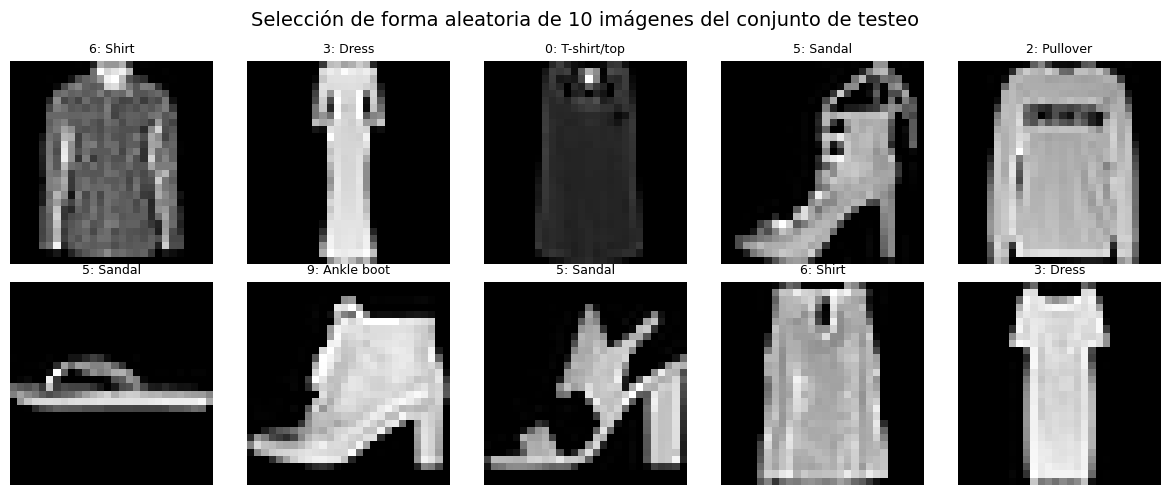

In [ ]:
# Importar las librerías necesarias
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos del dataset
# X_train, y_train: imágenes y etiquetas de entrenamiento
# X_test, y_test: imágenes y etiquetas de testeo
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


# Diccionario para mapear las etiquetas
label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Establecer semilla para reproducibilidad
np.random.seed(42)

# Seleccionar 10 índices aleatorios del conjunto de testeo
idx = np.random.choice(len(X_test), size=10, replace=False)

# Crear una figura para mostrar las imágenes en 2 filas y 5 columnas.
plt.figure(figsize=(12, 5))
for i, id in enumerate(idx):
    # subplot para cada imagen en la cuadrícula
    plt.subplot(2, 5, i + 1)
    # Mostrar la imagen actual en escala de grises
    plt.imshow(X_test[id], cmap="gray")
    # Ocultar los ejes
    plt.axis("off")
    # Agregar el título en formato etiqueta : descripción
    plt.title(f"{y_test[id]}: {label_map[y_test[id]]}", fontsize=9)

# Agregar el título general
plt.suptitle("Selección de forma aleatoria de 10 imágenes del conjunto de testeo", fontsize=14)
# Ajustar el espacio
plt.tight_layout()
plt.show()

# (b) Implementación de Análisis de Componentes Principales (PCA)

El **Análisis de Componentes Principales (PCA)** es una técnica ampliamente utilizada para la **reducción de dimensionalidad**. Se aplica en diversas áreas como compresión de datos con pérdida, extracción de características y visualización de datos. Su objetivo es encontrar un subespacio lineal de menor dimensionalidad, conocido como **subespacio principal** o **espacio latente**, donde los datos se proyectan. Es un método de aprendizaje no supervisado, lo que significa que depende únicamente de los valores de los datos de entrada y no utiliza información de etiquetas de clase.

Existen dos formulaciones comunes de PCA que conducen al mismo algoritmo:
- La primera lo define como la **proyección ortogonal de los datos** sobre un espacio lineal de menor dimensión de manera que **se maximiza la varianza de los puntos proyectados**. Las direcciones principales son aquellas a lo largo de las cuales los datos muestran la máxima varianza.
- La segunda lo define como la proyección lineal que **minimiza el costo de proyección promedio**, entendido como la distancia cuadrática media entre los puntos de datos y sus proyecciones. Esto corresponde a minimizar la suma de los cuadrados de los errores de proyección ortogonal.

El algoritmo central de PCA implica calcular la **media y la matriz de covarianza** del conjunto de datos. Luego, se encuentran los **M autovectores** de esta matriz de covarianza que corresponden a los **M autovalores más grandes**. Estos autovectores definen la base del subespacio principal. Loos autovectores se pueden encontrar mediante la descomposición de la matriz de covarianza o, alternativamente, utilizando la **Descomposición de Valores Singulares (SVD)** de la matriz de datos. Los vectores singulares derechos de la matriz de datos (previamente centrada) son proporcionales a los autovectores de la matriz de covarianza.

Una práctica común antes de aplicar PCA es **preprocesar los datos** normalizando cada característica para que tenga media cero y varianza unitaria, o simplemente restando la media.

A continuación, se implementa el algoritmo de PCA utilizando la función `numpy.linalg.eig`, para obtener una base ortonormal que permita representar los datos originales en un espacio de menor dimensión preservando la mayor cantidad de varianza posible.

- El método `__init__` es el constructor de la clase donde se inicializan las variables:
  - `mean_`: Media de los datos de entrenamiento.
  - `components_`: Componentes principales (autovectores), ordenados por sus autovalores correspondientes en orden descendente.
  - `singular_values_`: autovalores ordenados en orden descendente.
  - `transformed_cache_`: Diccionario destinado a almacenar transformaciones calculadas previamente (proyecciones en el espacio latente) para diferentes números de componentes.
- El método `fit` entrena el modelo PCA con los datos de entrada `X`.
  - Inicialmente, se centra el conjunto de datos restando la media de cada feature. Esto garantiza que la media del conjunto centrado sea nula para que la matriz de covarianza refleje exclusivamente la estructura de la varianza y correlación entre las variables, sin estar sesgada por desplazamientos del origen.

  - Posteriormente, se calcula la matriz de covarianza del conjunto de datos centrado utilizando la función `numpy.cov`. Como cada columna de la matriz `X_centered` corresponde a un feature y cada fila corresponde a una muestra, se debe usar `rowvar=False`. Esto indica a `numpy.cov` que debe calcular la matriz de covarianza donde los elementos $(i, j)$ representan la covarianza entre el feature $i$ (columna $i$) y el feature $j$ (columna $j$).
  - A continuación, se realiza la descomposición de la matriz de covarianza utilizando la función `numpy.linalg.eig`, que devuelve los autovalores y los autovectores. Los autovalores representan la varianza por cada dirección, mientras que los autovectores definen dichas direcciones (componentes principales).
  - Finalmente, se ordenan los autovalores y autovectores de forma decreciente según el valor de los autovalores, priorizando las direcciones que explican mayor varianza.
- El método `transform` proyecta los datos de entrada `X` sobre los primeros `k` componentes principales.
  - En primer lugar se centran los datos de entrada utilizando el promedio calculado durante el entrenamiento.
  - Luego se realiza la multiplicación matricial entre los datos centrados y los primeros `k` componentes principales.
- El método `inverse_transform` reconstruye una aproximación de los datos originales a partir de la representación en el espacio latente `U`.
- El método `fit_transform` es un método de conveniencia que primero ajusta el modelo PCA a los datos `X` y luego transforma `X` en el espacio latente utilizando `k` componentes.
- El método `transform_reconstruction` realiza tanto la transformación al espacio latente (con `k` componentes) como la transformación de vuelta al espacio original. Incluye una opción para usar resultados en chaché para la transformación si `use_previous_results` es `True` y el resultado para `k` ya está en `transformed_cache_`.
- El método `fit_reconstruction` combina `fit` con `transform_reconstruction`. Primero entrena el modelo PCA y luego reconstruye los datos utilizando `k` componentes. Dado que el ajuste (`fit`) se realiza desde cero, no es necesario utilizar resultados de transformación anteriores, por lo que `use_previous_results` se establece en `False`.

















In [ ]:
import numpy as np

class PCA:
  def __init__(self):
    self.mean_ = None             # Promedio de los datos
    self.components_ = None       # Autovectores (ordenados)
    self.singular_values_ = None  # Autovalores (ordenados)
    self.transformed_cache_ = {}   # Para guardar reconstrucciones previas

  # Etapa de entrenamiento. Se entrenan todos los autovectores, sin definir la
  # dimensión latente
  def fit(self, X):
    # Centrar datos
    self.mean_ = np.mean(X, axis=0)
    X_centered = X - self.mean_

    # Calcular matriz de covarianza
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Calcular autovalores y autovectores
    eigvals, eigvecs = np.linalg.eig(cov_matrix)

    # Ordenar por autovalores decrecientes
    idx = np.argsort(eigvals)[::-1]
    self.singular_values_ = eigvals[idx]
    self.components_ = eigvecs[:, idx]

  # Transformar del espacio original al espacio latente de dimensión k.
  def transform(self, X, k):
    X_centered = X - self.mean_
    return X_centered @ self.components_[:, :k]

  # Transformar del espacio latente al espacio original
  def inverse_transform(self, U):
    return U @ self.components_[:, :U.shape[1]].T + self.mean_

  # fit + transform
  def fit_transform(self, X, k):
    self.fit(X)
    return self.transform(X, k)

  # transform + inverse_transform. Debe incluir la posibilidad de aprovechar
  # reconstrucciones ya efectuadas con menos cantidad de componentes.
  def transform_reconstruction(self, X, k, use_previous_results=False):
    if use_previous_results and k in self.transformed_cache_:
      U = self.transformed_cache_[k]
    else:
      U = self.transform(X, k)
      if use_previous_results:
        self.transformed_cache_[k] = U
    return self.inverse_transform(U)

  # fit + transform_reconstruction. No es necesario utilizar resultados
  # anteriores pues entrenamiento hay uno solo.
  def fit_reconstruction(self, X, k):
    self.fit(X)
    return self.transform_reconstruction(X, k, use_previous_results=False)

# (c) Porcentaje de energía en función del número de componentes principales

Como se mencionó anteriormente, cada componente principal está asociado con un **autovalor** ($\lambda$). El tamaño de ese autovalor **mide la cantidad de varianza** de los datos que es capturada a lo largo de la dirección de ese componente principal (la matriz covarianza es simétrica y semidefinida positiva, entonces todos sus autovalores son reales y no negativos).

Cuando se selecciona un subconjunto de los $M$ primeros componentes principales (aquellos con los autovalores más grandes) para representar los datos, se elige las direcciones que explican la mayor parte de la varianza. El "porcentaje de energía preservada" por estos $M$ componentes se calcula como la **suma de los autovalores correspondientes a esos $M$ componentes dividida por la suma de todos los autovalores**. Es decir, si $\lambda_1,\lambda_2,\dots,\lambda_d$ son los autovalores (ordenados de mayor a menor), entonces:
- La **energía total** es $E_\text{total}=\sum_{i=1}^d \lambda_i$
- La **energía acumulada** hasta el componente $k$ es $E_k=\sum_{i=1}^k \lambda_i$
- El **porcentaje acumulado de energía** es:
$$P(k)=100\frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^d \lambda_i}$$

Mantener más componentes principales significa preservar una mayor proporción de la varianza total, lo que resulta en una reconstrucción más precisa de los datos originales del espacio de menor dimensión.

De manera inversa, el **porcentaje de energía perdida** es la varianza que no es capturada por los componentes principales seleccionados y se puede medir por la proporción de los **autovalores despreciados** (los de los componentes no seleccionados).

El gráfico resultante muestra el crecimiento del porcentaje de varianza acumulada a medida que se incrementa el número de componentes principales:
- Se observa un crecimiento rápido inicial. Con solo 20 componentes principales ya se acumula más del 70% de la varianza total.
- Con aproximadamente 100 componentes, se retiene alrededor del 90% de la energía, lo que indica que los primeros componentes contienen la información más relevante.
- A partir de $k=200$, el crecimiento de la curva se desacelera significativamente y agregar más componentes sólo mejora marginalmente la varianza acumulada.
- Con $k=784$ se alcanza el 100% de energía acumulada, es decir, no hay pérdida de información.


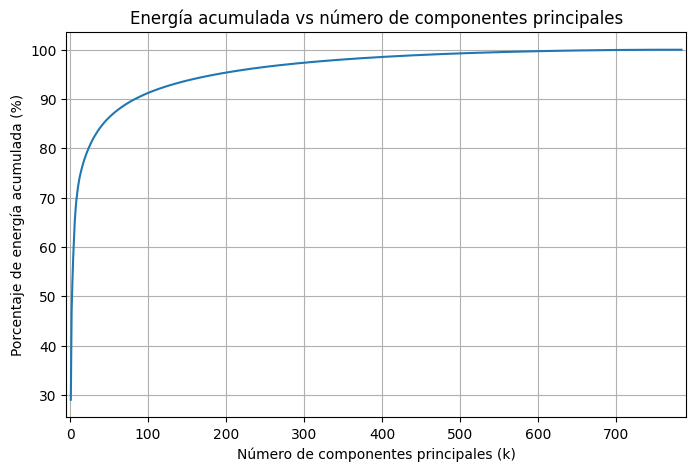

In [ ]:
# Aplanar las imágenes del conjunto de entrenamiento y normalizar los valores de píxeles
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0

# Crear una instancia de la clase PCA
pca = PCA()

# Entrenar el modelo PCA con los datos aplanados y normalizados
pca.fit(X_train_flat)

# Calcular la energía acumulada.
cumulative_energy = np.cumsum(pca.singular_values_/np.sum(pca.singular_values_)) * 100

# Crear una figura para el gráfico
plt.figure(figsize=(8, 5))

# Graficar la energía acumulada en función del número de componentes principales
# El eje x va de 1 al número total de componentes
plt.plot(np.arange(1, len(cumulative_energy)+1), cumulative_energy)
# Etiquetas y título del gráfico
plt.xlabel("Número de componentes principales (k)")
plt.ylabel("Porcentaje de energía acumulada (%)")
plt.title("Energía acumulada vs número de componentes principales")
# Mostrar la cuadrícula en el gráfico
plt.grid(True)
plt.xlim(-5,790)
plt.show()


# (d) Error cuadrático medio de testeo en función del número de componentes principales

El Error Cuadrático Medio (ECM) de testeo en función del número de componentes principales evalúa **la capacidad del modelo de PCA, entrenado sobre datos de entrenamiento, para generalizar al reconstruir datos del conjunto de testeo** utilizando solo los primeros `k` componentes principales.

Matemáticamente, para cada valor de $k$, se reconstruye cada imagen $x_i$ del test a partir de su proyección $\hat{x}_i^{(k)}$, y se calcula:

$$\text{ECM}(k)=\frac{1}{n}\sum_{i=1}^n\left\lVert x_i-\hat{x}_i^{(k)}\right\rVert^2$$
donde $n$ es la cantidad total de imágenes de testeo.

EL ECM es representa una perspectiva complementaria al porcentaje de energía de cuantificar **cuánta información se conserva o se pierde** al reducir la dimensionalidad a `k` componentes principales. Si $k$ es pequeño, la reconstrucción es burda y el ECM es alto. Por otro lado, si $k$ crece, se retiene más información y el ECM disminuye.

Adicionalmente, como se calcula sobre el conjunto de testeo, no solo mide la reconstrucción sino también la capacidad de generalizar a datos no visto durante el entrenamiento.

Un ECM bajo en testeo implica que el subespacio de PCA aprendido **capta bien la estructura global del dataset**.

Si el ECM de testeo es alto aunque la energía acumulada sea alta, puede indicar **sobreajuste o mala generalización** del modelo de PCA.

La implementación se compone de los siguientes pasos:
1. **Preparación de los datos**: Se cargan los datos de entrenamiento y testeo. Las imágenes se aplanan a vectores de 784 componentes, sin aplicar normalización (manteniendo su escala original de 0 a 255, para que **el ECM no se vea afectado por normalizaciones**).
2. **Entrenamiento del modelo de PCA**: Se instancia un objeto `PCA` y se entrena el conjunto `X_train_flat`. Esto permite calcular la media, la matriz de covarianza, los autovalores y autovectores.
3. **Transformación completa del conjunto de testeo**: Se proyectan todas las muestras de testeo al espacio latente de máxima dimensión (`k=784`), obteniendo la matriz `U_full` que contiene las coordenadas de cada imagen en base a las componentes principales.
4. **Reconstrucción incremental**: Para cada $k$, la imagen se puede reconstruir como:
$$\hat{X}^{(k)}=U_{:,:k}\,V_{:,:k}^T+\mu$$
donde $U_{:,:k}$ son las proyecciones sobre los primeros $k$ componentes, $V_{:,:k}$ son los autovectores y $\mu$ es la media de los datos. Esto implica **multiplicar matrices completas** para cada valor de $k$.

  Para **evitar repetir cómputos al recalcular la reconstrucción** para cada $k$ se puede adoptar un enfoque incremental y aprovechar la reconstrucción con  $k-1$ componentes principales teniendo en cuenta que:
  $$U_{:,:k}\,V_{:,:k}^T=\sum_{j=1}^ku_j\,v_j^T$$
  Es decir, se puede **sumar sucesivamente el aporte de cada componente**.
5. **Cálculo del ECM**: Se calcula el ECM entre la imagen original y su reconstrucción parcial y se guarda el resultado.
6. **Visualización**: Finalmente, se grafica el ECM en función de $k$.

A partir del gráfico resultante se observa claramente que:
- Para valores pequeños de $k$ (entre 1 y 100), el ECM disminuye de forma abrupta, lo que indica que **las primeras componentes principales captan la mayor parte de la varianza**.
- A partir de $k=200$, la tasa de disminución del ECM se vuelve más lenta porque las componentes restantes aportan **detalles menos relevantes**.
- A medida que $k$ se acerca al máximo, el ECM tiende a cero, lo que indica que la reconstrucción se vuelve prácticamente perfecta (salvo por errores numéricos). Esto confirma que PCA conserva toda la información si no se reduce la dimensionalidad.

Por lo tanto, similarmente al punto anterior, el gráfico confirma que se puede conservar la mayor parte de la información utilizando una fracción relativamente pequeña de componentes principales.








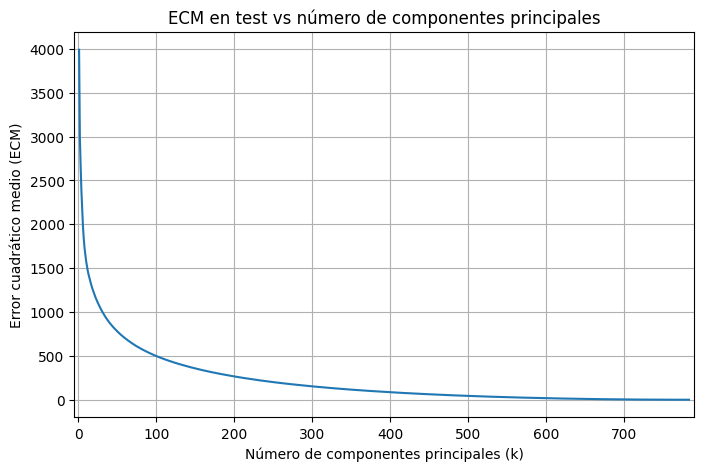

In [ ]:
from sklearn.metrics import mean_squared_error

# Dataset original (sin normalizar)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Entrenar PCA
pca = PCA()
pca.fit(X_train_flat)

# Transformación latente completa del set de testeo
U_full = pca.transform(X_test_flat, k=X_test_flat.shape[1])

# Preparar listas para guardar resultados
mse_list = []
ks = np.arange(1, X_test_flat.shape[1], 1)

# Inicializar la reconstrucción con 0 componentes (la media)
X_reconstructed = np.tile(pca.mean_, (X_test_flat.shape[0], 1))


for k in ks:
    # Obtener la proyección sobre el componente actual
    u_k = U_full[:, k-1] # Índice k-1 para el componente k-ésimo
    # Obtener el vector de componentes principales actual
    v_k = pca.components_[:, k-1]

    # Calcular el término de actualización
    update_term = np.outer(u_k, v_k)

    #Añadir el término de actualización a la reconstrucción anterior
    X_reconstructed = X_reconstructed + update_term

    # Calcular MSE entre imágenes originales y reconstruidas
    mse = mean_squared_error(X_test_flat, X_reconstructed)
    mse_list.append(mse)

# Graficar el ECM en función del número de componentes principales
plt.figure(figsize=(8, 5))
plt.plot(ks, mse_list)
# Etiquetas y título del gráfico
plt.xlabel("Número de componentes principales (k)")
plt.ylabel("Error cuadrático medio (ECM)")
plt.title("ECM en test vs número de componentes principales")
# Mostrar la cuadrícula en el gráfico
plt.grid(True)
plt.xlim(-5,790)
plt.show()

# (e) Reconsturcción utilizando 1, 100 y 784 componentes principales

A continuación, se realiza una comparación entre las imágenes originales y sus respectivas reconstrucciones usando tres configuraciones distintas:
- **Reconstrucción con 1 componente principal (k = 1)**: las imágenes reconstruidas aparecen como **manchas difusas**, donde sólo se conserva información muy global y se distinguen algunas formas, pero no los contornos.
- **Reconstrucción con 100 componentes principales (k = 100)**: se observa una **reconstrucción mucho más detallada**, es posible distinguir zapatillas, vestidos, camisas, etc. Aunque hay pérdida de definición y presencia de artefactos, la clase es reconocible en casi todos los casos.
- **Reconstrucción con 784 componentes principales (k = 784)**: las imágenes reconstruidas son prácticamente **idénticas a las originales** ya que en este caso no se realiza reducción de dimensionalidad y se alcanzan reconstrucciones perfectas salvo por errores numéricos.

A través de la comparación visual, se observa que la calidad de reconstrucción mejora al aumentar la cantidad de componentes principales. Esto evidencia el compromiso existente entre reducción de dimensionalidad y fidelidad.

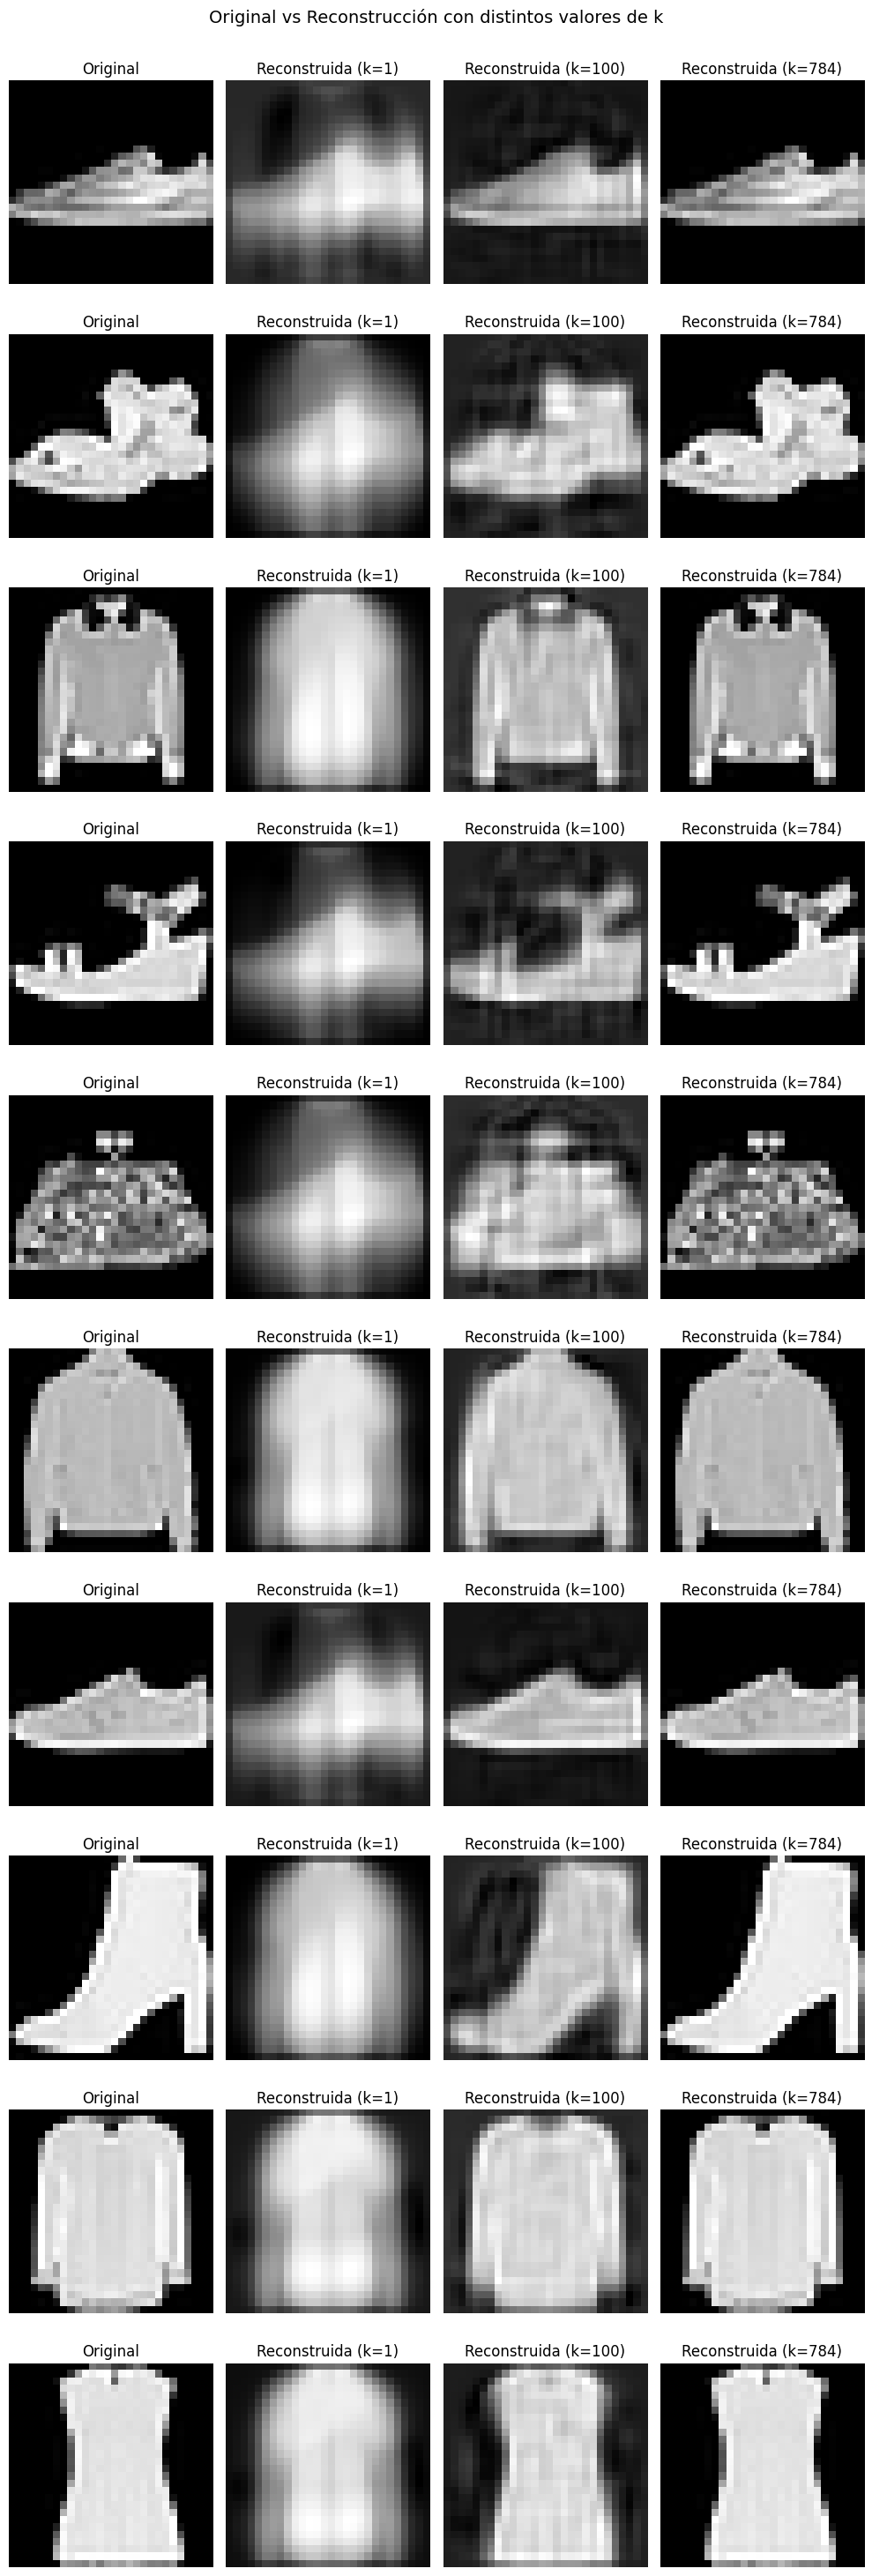

In [ ]:
# Seleccionar 10 imágenes al azar del set de testeo
np.random.seed(0)
sample_indices = np.random.choice(len(X_test_flat), size=10, replace=False)
X_sample = X_test_flat[sample_indices].reshape(10, -1)

# Para evitar recomputar, usamos la transformación completa
U_full = pca.transform(X_sample, k=784)

# Lista de valores de k a usar
ks = [1, 100, 784]
reconstructions = []

# Reconstruir con distintos valores de k
for k in ks:
    U_k = U_full[:, :k]
    V_k = pca.components_[:, :k]
    X_rec = U_k @ V_k.T + pca.mean_
    reconstructions.append(X_rec.reshape(-1, 28, 28))

# Mostrar: Fila 1 = originales, Fila 2-4 = reconstruidas con k=1, 100, 784
titles = ["Original"] + [f"Reconstruida (k={k})" for k in ks]

# Number of images to display in a row (original + reconstructions)
num_cols = 1 + len(ks)

plt.figure(figsize=(10,30))

for i in range(10): # Loop through each of the 10 sample images
    # Original Image
    plt.subplot(10, num_cols, i * num_cols + 1)
    plt.imshow(X_sample[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(titles[0])

    # Reconstructions
    for col, Xr in enumerate(reconstructions):
        plt.subplot(10, num_cols, i * num_cols + (col + 2))
        plt.imshow(Xr[i], cmap='gray')
        plt.axis('off')
        plt.title(titles[col + 1])

plt.suptitle("Original vs Reconstrucción con distintos valores de k", fontsize=14)

# Rely solely on tight_layout with rect to leave space for suptitle
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust this value as needed
plt.show()


# (f) Combinación con el dataset MNIST

Con el objetivo de evaluar el desempeño del modelo de PCA como **detector de anomalías**, se construye un conjunto de datos combinando imágenes del conjunto de testeo de `Fashion-MNIST` con imágenes del conjunto de testeo de `MNIST` (dígitos manuscritos).


In [ ]:
from tensorflow.keras.datasets import mnist

# Cargar el test set de MNIST (dígitos)
(_, _), (X_mnist, _) = mnist.load_data()
X_mnist_flat = X_mnist.reshape(X_mnist.shape[0], -1)  # (10000, 784)

# Crear dataset combinado
X_combined = np.vstack([X_test_flat, X_mnist_flat])
y_combined = np.hstack([np.zeros(len(X_test_flat)), np.ones(len(X_mnist_flat))])
# y=0: ropa (normal), y=1: dígitos (anomalías)

# Transformar y reconstruir usando k componentes
k = 50
U_combined = pca.transform(X_combined, k=k)
X_combined_rec = pca.inverse_transform(U_combined)

# Calcular error cuadrático medio por imagen
mse_per_image = np.mean((X_combined - X_combined_rec) ** 2, axis=1)

# (g) Detección de anomalías

La **detección de anomalías** es una tarea fundamental en aprendizaje automático no supervisado, cuyo objetivo es identificar muestras que **se desvían significativamente del comportamiento normal** observado en los datos. Estas observaciones anómalas, también llamadas **outliers**, pueden corresponder a errores, fraudes o eventos raros de interés.

El paradigma para la detección de anomalías se basa en una idea clave: durante el entrenamiento, se aprenden **patrones** presentes en los datos de entrenamiento, que se asumen como "normales". Como resultado, la reconstrucción de estos datos se puede hacer con cierta facilidad y se espera que una muestra que no cumpla con los patrones aprendidos sea más difícil de reconstruir.

Por lo tanto, la **dificultad o el error de reconstrucción** de una muestra puede servir como indicador de si esa muestra es normal o anómala.

Para que esto funcione eficazmente, el modelo de PCA debe aprender la **naturaleza o estructura** de los datos (su manifold) en lugar de simplemente memorizar el conjunto de entrenamiento. Si el modelo simplemente aprende la función identidad o memoriza las muestras, sería capaz de reconstruir casi cualquier entrada (normal o anómala) con bajo error, lo que lo haría inútil para la detección de anomalías.

La reducción de la dimensionalidad fuerza al modelo a **priorizar qué aspectos de la entrada debe copiar** (el subespacio de PCA).

En este trabajo se entrenó al modelo con imágenes de indumentaria, que se consideran normales. Ahora, se evaluará la capacidad del modelo para detectar como anómalas a las imágenes de **dígitos manuscritos** (MNIST).

En la implementación, cada imagen se proyecta al subespacio generado por las primaras $k$ componentes principales y luego se reconstruye.

Luego, se calcula el **error cuadrático medio (ECM)** entre la imagen original y su reconstrucción. Si ese error supera un **umbral** $\tau$, la muestra se clasifica como **anómala**:
$$\text{ECM}(x_i)>\tau\Rightarrow x_i\text{ es una anomalía}$$

Para evaluar la capacidad del modelo como detector se utiliza la **curva ROC** y la **AUC** para comparar el rendimiento para todos los umbrales posibles.

Considerando esta métrica, el **umbral óptimo** se selecciona como el que produce en la curva ROC el punto más cercano al correspondiente a una tasa de falsos positivos igual a $0$ y una tasa de verdaderos positivos igual a $1$.

A partir de las curvas ROC obtenidas en función de $k$ se pueden realizar las siguientes observaciones:
- Para $k=100$, el modelo alcanza un valor de $\text{AUC}=0.948$, lo que indica una excelente separación entre muestras normales (indumentaria) y muestras anómalas (dígitos). Este valor representa el mejor compromiso entre fidelidad de reconstrucción y sensibilidad ante anomalías. El punto óptimo se obtiene con un umbral de reconstrucción $\tau_\text{opt}\simeq 893$ con baja tasa de falsos positivos y alta tasa de detección de anomalías.
- Por otro lado, con $k=1$ la dimensión del modelo es muy reducida y no capta adecuadamente la estructura de las imágenes normales, lo que impacta en la discriminación entre clases. Su $\text{AUC}=0.761$ es considerablemente menor, y el umbral requerido para separar clases es muy alto $\tau_\text{opt}\simeq 4397$
- Para $k=786$ (sin reducción), el modelo reconstruye tanto las muestras normales como las anómalas con alta precisión, lo que reduce su poder de discriminación. El $\text{AUC}=0.786$ y el umbral óptimo se encuentra próximo a cero. Esto evidencia que utilizar toda la dimensionalidad original elimina la capacidad del modelo de diferenciar entre patrones conocidos y desconocidos.

In [ ]:
# Implementación del TPS03 - Regresión Logística
def compute_roc(y_true, y_scores, thresholds):
  tpr_list = []
  fpr_list = []

  for thresh in thresholds:
    # Clasificación binaria según el umbral
    y_pred = (y_scores >= thresh).astype(int) #Convierte a un array de enteros

    # Cálculo de VP, VN, FP, FN
    # Verdaderos positivos
    TP = np.sum((y_pred == 1) & (y_true == 1))
    # Verdaderos negativos
    TN = np.sum((y_pred == 0) & (y_true == 0))
    # Falsos positivos
    FP = np.sum((y_pred == 1) & (y_true == 0))
    # Falsos negativos
    FN = np.sum((y_pred == 0) & (y_true == 1))

    # Cálculo de TPR y FPR
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0 # evita una división por cero
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    tpr_list.append(TPR)
    fpr_list.append(FPR)

  return np.array(fpr_list), np.array(tpr_list), thresholds

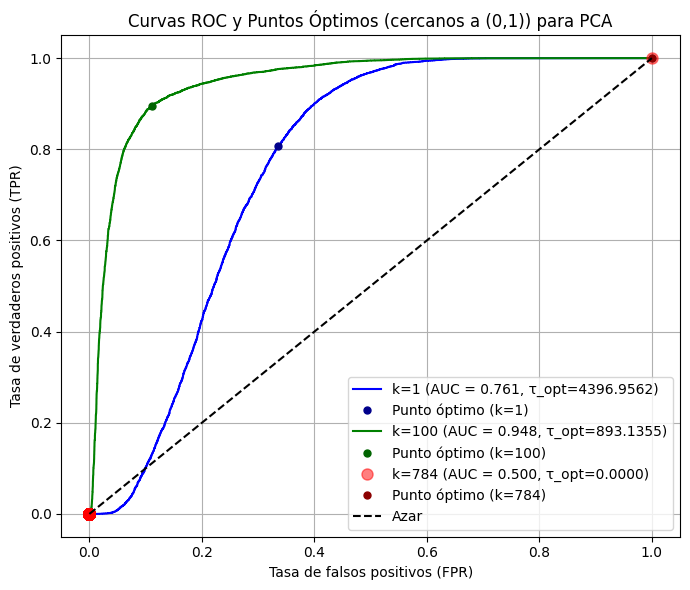


Resumen de umbrales óptimos (distancia a (0,1)):
  k = 1: τ = 4396.956212
  k = 100: τ = 893.135510
  k = 784: τ = 0.000000


In [ ]:
from sklearn.metrics import auc

ks = [1, 100, 784]

# Para guardar y imprimir el resumen al final
optimal_taus_distance = []

# Crear la figura
plt.figure(figsize=(7, 6))

# Definir colores
colors = ['blue', 'green', 'red']
colors2 = ['darkblue', 'darkgreen', 'darkred']

for i, k in enumerate(ks):
    # Transformar y reconstruir
    X_rec = pca.transform_reconstruction(X_combined, k)

    # Error cuadrático por muestra
    mse = np.mean((X_combined - X_rec) ** 2, axis=1)

    mse[mse < 1e-20] = 0.0

    # Calcular curva ROC (FPR, TPR, y umbrales)

    fpr, tpr, thresholds = compute_roc(y_combined, mse, np.linspace(np.min(mse),np.max(mse)+1e-15,1000) if k==784 else np.sort(np.unique(mse)))
    roc_auc = auc(fpr, tpr)

    # Calcular distancia euclidiana a (0,1) para cada punto de la curva ROC
    ideal_point = np.array([0, 1])
    distances = np.sqrt((fpr - ideal_point[0])**2 + (tpr - ideal_point[1])**2)

    # Encontrar el índice del punto con la distancia mínima
    min_distance_index = np.argmin(distances)

    # Obtener el umbral correspondiente a la distancia mínima
    optimal_tau_distance = thresholds[min_distance_index]
    # Guardar el umbral óptimo para este k
    optimal_taus_distance.append((k, optimal_tau_distance))

    # Graficar la curva ROC para este k
    if k == 784:
      plt.plot(fpr, tpr, 'o', color=colors[i], markersize=8, alpha=0.5, label=f'k={k} (AUC = {roc_auc:.3f}, τ_opt={optimal_tau_distance:.4f})')
    else:
      plt.plot(fpr, tpr, color=colors[i], label=f'k={k} (AUC = {roc_auc:.3f}, τ_opt={optimal_tau_distance:.4f})')

    # Graficar el punto óptimo en la curva ROC para este k
    plt.plot(fpr[min_distance_index], tpr[min_distance_index],'o', color=colors2[i], markersize=5, label=f'Punto óptimo (k={k})')


# Graficar la línea de clasificador aleatorio
plt.plot([0, 1], [0, 1], 'k--', label='Azar')

# Título y etiquetas del gráfico
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curvas ROC y Puntos Óptimos (cercanos a (0,1)) para PCA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nResumen de umbrales óptimos (distancia a (0,1)):")
for k, tau in optimal_taus_distance:
    print(f"  k = {k}: τ = {tau:.6f}")